In [ ]:
from google.colab import files
from PIL import Image
import torch
from diffusers import StableDiffusionImg2ImgPipeline, DDIMScheduler

from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import ipywidgets as widgets
from diffusers.models import AutoencoderKL
from sklearn.manifold import TSNE

import torchvision.transforms as T
!pip install diffusers accelerate transformers torchvision
#Deepseek used for code assistance
#Make sure you're on the GPU runtime

In [ ]:
# Load model
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    scheduler=DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
)
pipe = pipe.to("cuda")


# Load pretrained VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
#vae.eval()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
'''
GUI GOES HERE
USER SHOULD BE ABLE TO:
- UPLOAD THEIR OWN IMAGE (FOR DEMO LETS USE A PICTURE OF ROCKY. PROFESSORS LOVE STUFF LIKE THAT)
- THE CODE BELOW WORKS FOR FILE INPUT BUT IF IT COULD LOOK MORE VISUALLY APPEALING OR BE WRAPPED WITHIN A GUI, THATD BE GOOD
- CHOOSE A STYLE FROM A PREDEFINED STYLE LIST: THINK ANIME, CARTOON, VAN GOGH...ETC.
- SAVE THE CHOSEN STYLE AS THE 'PROMPT'

- IF POSSIBLE, ADD A FRAME IN THE GUI FOR IMAGES. TRY AND WRITE THIS AS A WHILE LOOP SO THE KIDS JUST SEE SOME IMAGES WHILE THE ACTUAL PROCESS IS RUNNING

- I'M GOING TO WORK ON SOME PICTURES TO 'VISUALIZE' THE PROCESS. HERE'S THE STORY PITCH FOR AN ANALOGY OF THE PROCESS :
    - Characters: Scientist (User), Robot (VAE), Artist (Diffuser).
    - Analogies: Machine (Encoder and Decoder), Door (bottleneck and latent space)
    1. The scientist gets a picture he wants to change the style of. He tries to run straight to the artist, but his picture is too big to fit through the door.
    2. Above the door is a sign that says 'latent-space only'
    3. A robot sitting off to the side taps on a machine. The scientist hands the picture to the robot who runs it through the machine.
    4. Out of the machine comes small, blurry version of the picture. The robot hands this to the scientist who can now fit through the door into 'latent space'.
    5. Into the latent space, the scientist meets an artist who takes the new condensed picture. He slowly starts spraying it with spray paint until it is just noise.
    6. The artist turns to the scientist and asks him to select a style from the 'style wall'.
    7. The scientist chooses his style, and the artist begins removing noise with a paint brush.
    8. Finally, a new picture is created. It is still blurry and small like the other one.
    9. The scientist goes back through the door to the robot, who switches the setting on the machine from 'encode' to 'decode'
    10. The picture goes through the machine in the opposite direct now, and out pops the new picture in the scientist's preferred style.


'''

In [ ]:
print("Please upload your image")
uploaded = files.upload()

print(f"Uploaded image")

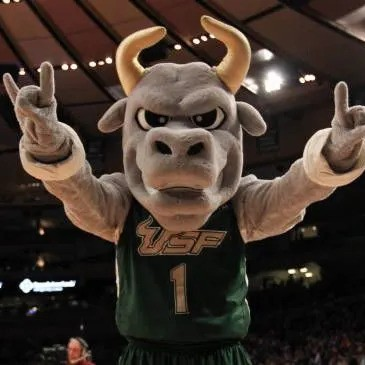

In [ ]:
# Load and preprocess image
image_name = next(iter(uploaded)) # Get the first filename from the dictionary

image = Image.open(image_name).convert("RGB")
display(image)

transform = T.Compose([
    T.Resize(512),
    T.CenterCrop(512),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])  # VAE expects [-1, 1]
])
x = transform(image).unsqueeze(0)  # shape: [1, 3, 512, 512]

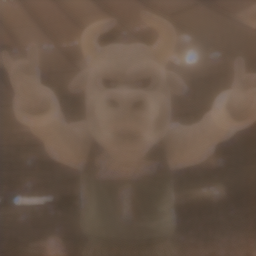

In [ ]:
with torch.no_grad():
    latent = vae.encode(x).latent_dist.sample() * 0.18215  # scale factor used in SD
    reconstructed = vae.decode(latent).sample

# Convert back to image
reconstructed = (reconstructed / 2 + 0.5).clamp(0, 1)
reconstructed_image = T.ToPILImage()(reconstructed.squeeze())

# Resize it to mimic latent space enconding

new_size = (256, 256)  # diffusion model typically expects 512x512, but we'll go smaller for visualization purposes
reconstructed_image = reconstructed_image.resize(new_size, Image.Resampling.LANCZOS)

display(reconstructed_image)



2. Adding noise to the image


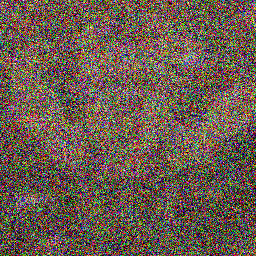

In [ ]:

# 2. Add noise to the enocoded, latent image
# This mimics when it gets to the 'diffuser'

#if you have time, make this into a loop where it goes through different levels of adding noise, starting with little noise and
#bulding on until its full noise.

print("\n2. Adding noise to the image")


# Convert to numpy and add noise
img_array = np.array(reconstructed_image, dtype=np.float32) / 255.0
noise = np.random.normal(0, 0.3, img_array.shape)
noisy_array = np.clip(img_array + noise, 0, 1)
noisy_img = Image.fromarray((noisy_array * 255).astype(np.uint8))


display(noisy_img)


Running img2img diffusion...


  0%|          | 0/12 [00:00<?, ?it/s]

Saved final generation as 'final_generation.png'


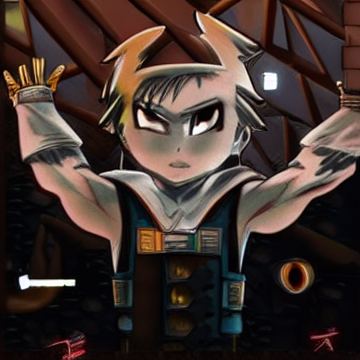


Process complete!


In [ ]:
#this is where everything actually happens. the other code is just representative of this process.


print("Running img2img diffusion...")
prompt = "anime style"   #make this a variable

'''
strength=0.7: This parameter controls how much the input image is transformed. A higher strength means more transformation, potentially moving further away from the original image.

guidance_scale=7.5: This parameter influences how strongly the diffusion process follows the text prompt. Higher values mean the generated image will adhere more closely to the prompt.

num_inference_steps=25: This sets the number of steps in the diffusion process. More steps generally lead to higher quality results but take longer to compute.


^^^ if we could add some of those steps as variables to the gui, it would be more interactive and dynamic.
'''

result = pipe(
    prompt=prompt,
    image=image,
    strength=0.5,
    guidance_scale=5,
    num_inference_steps=25 # if we make this a variable we could somehow visualize this in correlational with how many noise 'iterations' it goes through
).images[0]


#BEFORE WE SHOW THIS TO THE USER, WE NEED TO SHOW ANOTHER LATENT TRANSFORMATION. THE IMAGE PRIOR TO THE FINAL 'DECODED ONE'.

result.save("final_generation.png")

display(result)

while this technially is the final step, we need to add another latent transformation. pretty much taking this generated image, not showing it to the user yet, and encoding it to show how it likely looked coming out of the diffuser.

once we show that, we can then show this final image.

** one thing we should add before the latent transformation, is some sort of 'NSFW-checker'

** stable diffusion has one built in, but it will just return a black square if it thinks theres nsfw content.

** if you could add like "if all pixels are black, regenerate. if not, proceed".